<a href="https://colab.research.google.com/github/SanskarJadhav/DeepLearning/blob/main/LSTM_Flight_Trajectory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Final Implementation

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [39]:
from glob import glob
csvs = glob('/content/*.csv')
csv_list = [csv[:-5] for csv in csvs]
csv_list.sort()

In [40]:
datelist = []
for i in csv_list:
  daynum = i[9:11]
  datelist.append(int(daynum))
print(datelist)

[12, 13, 14, 15, 16]


In [41]:
dataframelist = []
for i in csv_list:
  df_new = pd.read_csv(i+'1.csv')
  df_new = df_new.dropna(subset=['Time (IST)']).reset_index(drop=True)
  daylist = np.array(df_new['Time (IST)'])
  strday = daylist[0][:3]
  df_new['date_time'] = ''
  for j in range(df_new.shape[0]):
    day2 = daylist[j][:3]
    if(strday==day2):
      df_new['date_time'][j] = i[9:] + daylist[j][3:]
    else:
      df_new['date_time'][j] = str(int(i[9:11]) + 1) + i[11:] + daylist[j][3:]
  dataframelist.append(df_new)

In [42]:
for df in dataframelist:
  df['date_time'] = pd.to_datetime(df['date_time'], format='%d-%m-%Y %H:%M:%S')
  df['day'] = df['date_time'].apply(lambda x: x.day)
  df['hour'] = df['date_time'].apply(lambda x: x.hour)
  df['minute'] = df['date_time'].apply(lambda x: x.minute)
  df['second'] = df['date_time'].apply(lambda x: x.second)

## For Latitude

In [43]:
df_update = dataframelist[0].loc[:,['date_time','Latitude', 'day', 'hour','minute','second']]
for df in dataframelist[1:]:
  df_lat=df.loc[:,['date_time','Latitude', 'day', 'hour','minute','second']]
  df_update = pd.concat([df_update, df_lat], axis=0)
df_update

,date_time,Latitude,day,hour,minute,second
0,2023-03-12 22:47:37,17.2295,12,22,47,37
1,2023-03-12 22:48:07,17.2297,12,22,48,7
2,2023-03-12 22:48:27,17.2313,12,22,48,27
3,2023-03-12 22:48:46,17.2436,12,22,48,46
4,2023-03-12 22:49:06,17.2665,12,22,49,6
...,...,...,...,...,...,...
200,2023-03-17 00:08:02,19.0898,17,0,8,2
201,2023-03-17 00:08:12,19.0898,17,0,8,12
202,2023-03-17 00:09:12,19.0892,17,0,9,12
203,2023-03-17 00:09:28,19.0890,17,0,9,28


In [44]:
stat, p = stats.normaltest(df_update.Latitude)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=5080.954, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: -1.5671928585230261
Skewness of normal distribution: -0.057936746607874456


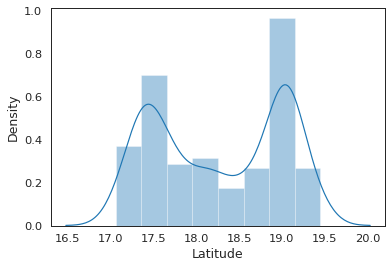

In [45]:
sns.distplot(df_update.Latitude);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df_update.Latitude)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df_update.Latitude)))

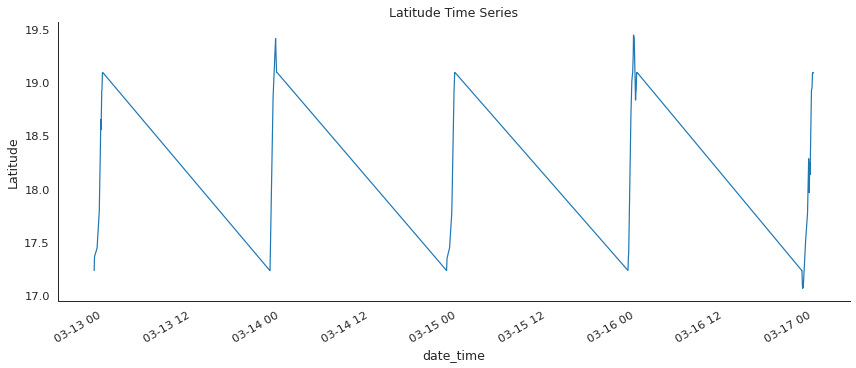

In [46]:
dfspec=df_update.loc[:,['date_time','Latitude']]
dfspec.set_index('date_time',inplace=True)
dfspec.plot(figsize=(12,5))
plt.ylabel('Latitude')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Latitude Time Series')
sns.despine(top=True)
plt.show();

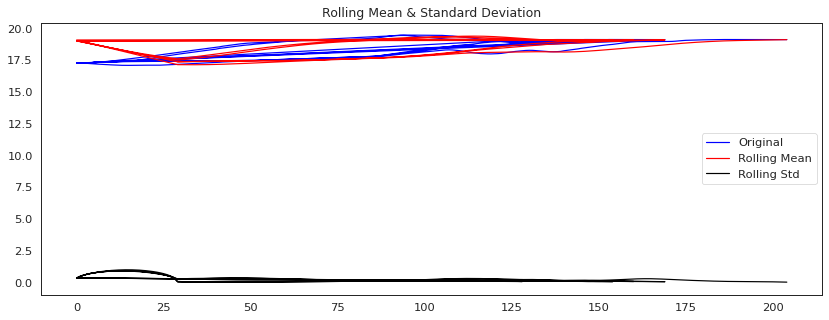

<Results of Dickey-Fuller Test>
Test Statistic                 -2.6094
p-value                         0.0911
#Lags Used                      0.0000
Number of Observations Used   819.0000
Critical Value (1%)            -3.4384
Critical Value (5%)            -2.8651
Critical Value (10%)           -2.5687
dtype: float64


In [47]:
df2=df_update.copy()
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.Latitude.dropna())

In [53]:
dataset = df_update.Latitude.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
test_size = dataframelist[-1].shape[0]
train_size = len(dataset) - test_size
train, test = dataset[:train_size,:], dataset[train_size:,:]

def create_dataset(dataset, look_back, look_ahead):
    X, Y = [], []
    for i in range(len(dataset)-look_back-look_ahead):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back + look_ahead - 1, 0])
    return np.array(X), np.array(Y)
    
look_back = 5
look_ahead = 1
X_train, Y_train = create_dataset(train, look_back, look_ahead)
X_test, Y_test = create_dataset(test, look_back, look_ahead)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [54]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=15, batch_size=32, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5)], verbose=1, shuffle=False)

model.summary()

Epoch 1/15
20/20 [==============================] - 4s 32ms/step - loss: 0.2481 - val_loss: 0.0785
Epoch 2/15
20/20 [==============================] - 0s 8ms/step - loss: 0.0520 - val_loss: 0.0091
Epoch 3/15
20/20 [==============================] - 0s 7ms/step - loss: 0.0131 - val_loss: 0.0089
Epoch 4/15
20/20 [==============================] - 0s 6ms/step - loss: 0.0140 - val_loss: 0.0059
Epoch 5/15
20/20 [==============================] - 0s 6ms/step - loss: 0.0119 - val_loss: 0.0051
Epoch 6/15
20/20 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0045
Epoch 7/15
20/20 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0037
Epoch 8/15
20/20 [==============================] - 0s 7ms/step - loss: 0.0104 - val_loss: 0.0031
Epoch 9/15
20/20 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0027
Epoch 10/15
20/20 [==============================] - 0s 7ms/step - loss: 0.0096 - val_loss: 0.0023
Epoch 11/15
20/20 

In [55]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

7/7 [==============================] - 0s 3ms/step
Train Mean Absolute Error: 0.08164585140553382
Train Root Mean Squared Error: 0.19515102328368542
Test Mean Absolute Error: 0.06657493583900545
Test Root Mean Squared Error: 0.08141704031365471


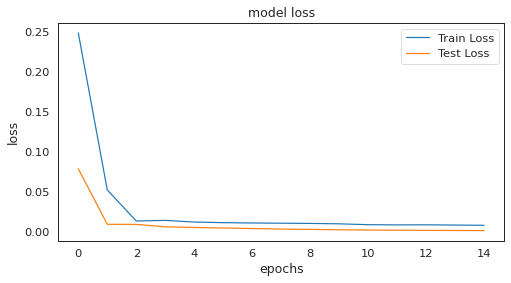

In [56]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

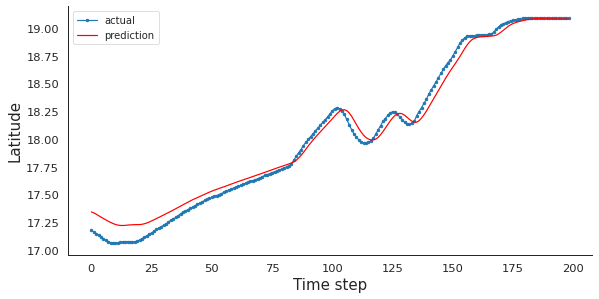

In [57]:
aa=[x for x in range(Y_test.shape[1])]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Latitude', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=10)
plt.show();

## For Longitude

In [58]:
df_update = dataframelist[0].loc[:,['date_time','Longitude', 'day', 'hour','minute','second']]
for df in dataframelist[1:]:
  df_long=df.loc[:,['date_time','Longitude', 'day', 'hour','minute','second']]
  df_update = pd.concat([df_update, df_long], axis=0)
df_update

,date_time,Longitude,day,hour,minute,second
0,2023-03-12 22:47:37,78.4585,12,22,47,37
1,2023-03-12 22:48:07,78.4863,12,22,48,7
2,2023-03-12 22:48:27,78.5084,12,22,48,27
3,2023-03-12 22:48:46,78.5293,12,22,48,46
4,2023-03-12 22:49:06,78.5394,12,22,49,6
...,...,...,...,...,...,...
200,2023-03-17 00:08:02,72.9515,17,0,8,2
201,2023-03-17 00:08:12,72.9443,17,0,8,12
202,2023-03-17 00:09:12,72.8994,17,0,9,12
203,2023-03-17 00:09:28,72.8878,17,0,9,28


In [59]:
stat, p = stats.normaltest(df_update.Longitude)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=641.961, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: -1.2051496435732894
Skewness of normal distribution: 0.5453027259832648


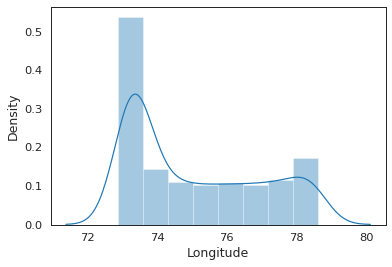

In [60]:
sns.distplot(df_update.Longitude);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df_update.Longitude)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df_update.Longitude)))

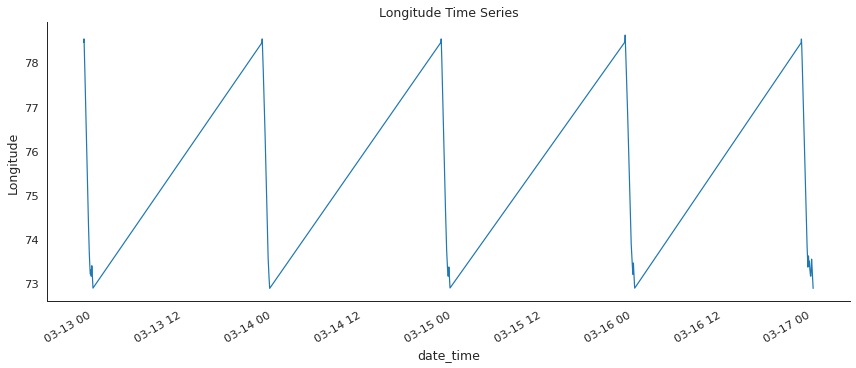

In [61]:
dfspec=df_update.loc[:,['date_time','Longitude']]
dfspec.set_index('date_time',inplace=True)
dfspec.plot(figsize=(12,5))
plt.ylabel('Longitude')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Longitude Time Series')
sns.despine(top=True)
plt.show();

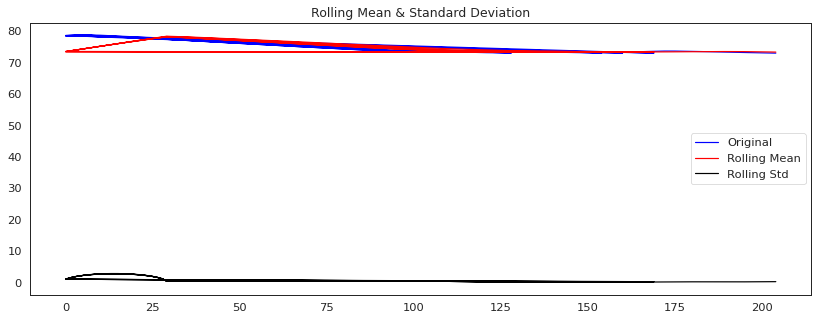

<Results of Dickey-Fuller Test>
Test Statistic                 -3.1293
p-value                         0.0245
#Lags Used                      0.0000
Number of Observations Used   819.0000
Critical Value (1%)            -3.4384
Critical Value (5%)            -2.8651
Critical Value (10%)           -2.5687
dtype: float64


In [62]:
df2=df_update.copy()
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.Longitude)

In [63]:
dataset = df_update.Longitude.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
test_size = dataframelist[-1].shape[0]
train_size = len(dataset) - test_size
train, test = dataset[:train_size,:], dataset[train_size:,:]

def create_dataset(dataset, look_back, look_ahead):
    X, Y = [], []
    for i in range(len(dataset)-look_back-look_ahead):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back + look_ahead - 1, 0])
    return np.array(X), np.array(Y)
    
look_back = 5
look_ahead = 1
X_train, Y_train = create_dataset(train, look_back, look_ahead)
X_test, Y_test = create_dataset(test, look_back, look_ahead)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [64]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=15, batch_size=32, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5)], verbose=1, shuffle=False)

model.summary()

Epoch 1/15
20/20 [==============================] - 4s 34ms/step - loss: 0.2027 - val_loss: 0.0619
Epoch 2/15
20/20 [==============================] - 0s 7ms/step - loss: 0.0681 - val_loss: 0.0147
Epoch 3/15
20/20 [==============================] - 0s 7ms/step - loss: 0.0223 - val_loss: 0.0102
Epoch 4/15
20/20 [==============================] - 0s 7ms/step - loss: 0.0164 - val_loss: 0.0079
Epoch 5/15
20/20 [==============================] - 0s 7ms/step - loss: 0.0150 - val_loss: 0.0052
Epoch 6/15
20/20 [==============================] - 0s 7ms/step - loss: 0.0134 - val_loss: 0.0037
Epoch 7/15
20/20 [==============================] - 0s 8ms/step - loss: 0.0122 - val_loss: 0.0025
Epoch 8/15
20/20 [==============================] - 0s 7ms/step - loss: 0.0115 - val_loss: 0.0016
Epoch 9/15
20/20 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0011
Epoch 10/15
20/20 [==============================] - 0s 7ms/step - loss: 0.0104 - val_loss: 7.1818e-04
Epoch 11/15
20

In [65]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

7/7 [==============================] - 0s 3ms/step
Train Mean Absolute Error: 0.16556746036899456
Train Root Mean Squared Error: 0.5309835680585702
Test Mean Absolute Error: 0.0922009317094039
Test Root Mean Squared Error: 0.10565015896966748


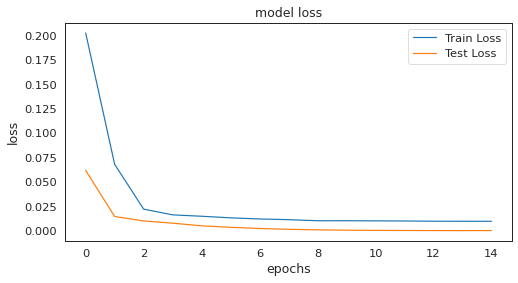

In [66]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

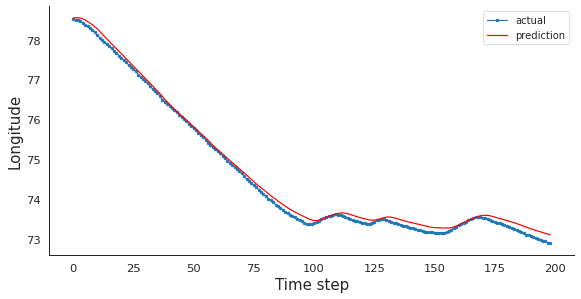

In [67]:
aa=[x for x in range(Y_test.shape[1])]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:], marker='.', label="actual")
plt.plot(aa, test_predict[:][:,0], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Longitude', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=10)
plt.show();

## Altitude

In [68]:
df_update = dataframelist[0].loc[:,['date_time','meters', 'day', 'hour','minute','second']]
for df in dataframelist[1:]:
  df_alt=df.loc[:,['date_time','meters', 'day', 'hour','minute','second']]
  df_update = pd.concat([df_update, df_alt], axis=0)
df_update

,date_time,meters,day,hour,minute,second
0,2023-03-12 22:47:37,815.0000,12,22,47,37
1,2023-03-12 22:48:07,1036.0000,12,22,48,7
2,2023-03-12 22:48:27,1212.0000,12,22,48,27
3,2023-03-12 22:48:46,1433.0000,12,22,48,46
4,2023-03-12 22:49:06,1745.0000,12,22,49,6
...,...,...,...,...,...,...
200,2023-03-17 00:08:02,450.0000,17,0,8,2
201,2023-03-17 00:08:12,404.0000,17,0,8,12
202,2023-03-17 00:09:12,160.0000,17,0,9,12
203,2023-03-17 00:09:28,107.0000,17,0,9,28


In [69]:
stat, p = stats.normaltest(df_update.meters)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=6837.796, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: -1.4740191352184537
Skewness of normal distribution: -0.17238728218291083


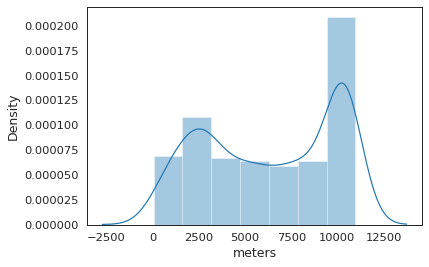

In [70]:
sns.distplot(df_update.meters);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df_update.meters)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df_update.meters)))

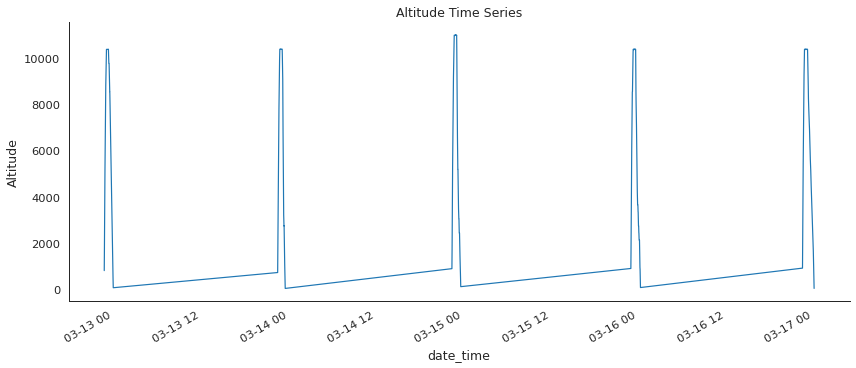

In [71]:
dfspec=df_update.loc[:,['date_time','meters']]
dfspec.set_index('date_time',inplace=True)
dfspec.plot(figsize=(12,5))
plt.ylabel('Altitude')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Altitude Time Series')
sns.despine(top=True)
plt.show();

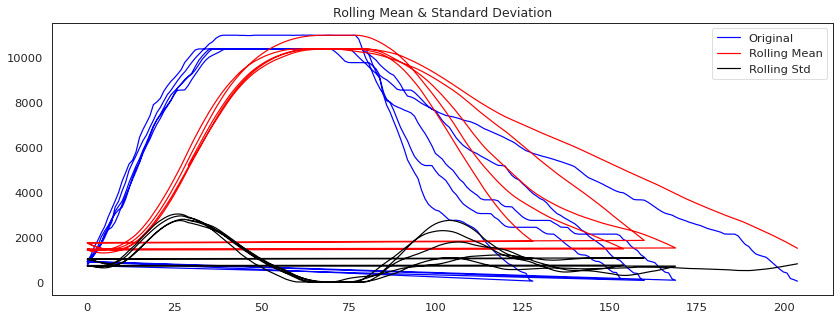

<Results of Dickey-Fuller Test>
Test Statistic                 -4.5202
p-value                         0.0002
#Lags Used                      4.0000
Number of Observations Used   815.0000
Critical Value (1%)            -3.4384
Critical Value (5%)            -2.8651
Critical Value (10%)           -2.5687
dtype: float64


In [72]:
df2=df_update.copy()
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.meters)

In [79]:
dataset = df_update.meters.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
test_size = dataframelist[-1].shape[0]
train_size = len(dataset) - test_size
train, test = dataset[:train_size,:], dataset[train_size:,:]

def create_dataset(dataset, look_back, look_ahead):
    X, Y = [], []
    for i in range(len(dataset)-look_back-look_ahead):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back + look_ahead - 1, 0])
    return np.array(X), np.array(Y)
    
look_back = 5
look_ahead = 1
X_train, Y_train = create_dataset(train, look_back, look_ahead)
X_test, Y_test = create_dataset(test, look_back, look_ahead)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [80]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=15, batch_size=32, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5)], verbose=1, shuffle=False)

model.summary()

Epoch 1/15
20/20 [==============================] - 3s 37ms/step - loss: 0.2388 - val_loss: 0.0934
Epoch 2/15
20/20 [==============================] - 0s 7ms/step - loss: 0.0496 - val_loss: 0.0061
Epoch 3/15
20/20 [==============================] - 0s 6ms/step - loss: 0.0084 - val_loss: 0.0053
Epoch 4/15
20/20 [==============================] - 0s 8ms/step - loss: 0.0069 - val_loss: 0.0037
Epoch 5/15
20/20 [==============================] - 0s 7ms/step - loss: 0.0063 - val_loss: 0.0032
Epoch 6/15
20/20 [==============================] - 0s 7ms/step - loss: 0.0055 - val_loss: 0.0028
Epoch 7/15
20/20 [==============================] - 0s 8ms/step - loss: 0.0051 - val_loss: 0.0024
Epoch 8/15
20/20 [==============================] - 0s 7ms/step - loss: 0.0047 - val_loss: 0.0022
Epoch 9/15
20/20 [==============================] - 0s 7ms/step - loss: 0.0043 - val_loss: 0.0020
Epoch 10/15
20/20 [==============================] - 0s 7ms/step - loss: 0.0043 - val_loss: 0.0019
Epoch 11/15
20/20 

In [81]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

7/7 [==============================] - 0s 3ms/step
Train Mean Absolute Error: 402.4548361131097
Train Root Mean Squared Error: 544.6113711013879
Test Mean Absolute Error: 262.64106919291385
Test Root Mean Squared Error: 432.1353216249508


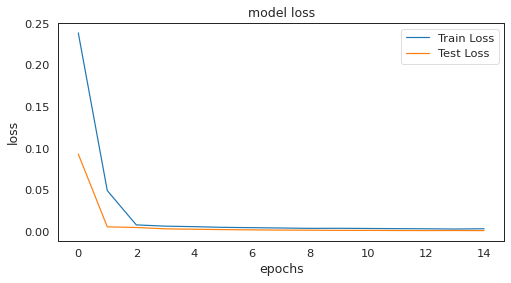

In [82]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

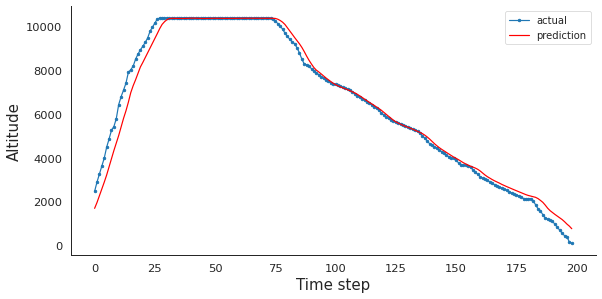

In [83]:
aa=[x for x in range(Y_test.shape[1])]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:], marker='.', label="actual")
plt.plot(aa, test_predict[:][:,0], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Altitude', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=10)
plt.show();